# Extremes - Demo

In [14]:
import autoroot
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray
from geo_toolz._src.masks.country import add_country_mask
from geo_toolz._src.masks.land import add_land_mask
from geo_toolz._src.masks.ocean import add_ocean_mask
from geo_toolz._src.validation.coords import validate_longitude, validate_latitude
from geo_toolz._src.encoders.time import time_rescale, time_unrescale
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
!ls "/pool/datos/reanalisis/era5/hourly/europe/025"

t2m


In [16]:
data_dir = '/pool/datos/reanalisis/era5/hourly/europe/025/t2m/*.nc'

In [17]:
def preprocess(ds):
    ds = validate_latitude(ds)
    ds = validate_longitude(ds)
    # ds = ds.sortby(["time", "lon", "lat"])

    ds = ds.pint.quantify({"t2m": "kelvin"})
    ds["t2m"] = ds["t2m"].pint.to("degC")
    ds = ds.pint.dequantify()
    return ds

ds = xr.open_mfdataset(
    data_dir, preprocess=preprocess, engine="netcdf4"
)

In [18]:
ds

<xarray.Dataset>
Dimensions:  (time: 639912, lat: 181, lon: 301, expver: 2)
Coordinates:
  * lon      (lon) float32 -25.0 -24.75 -24.5 -24.25 ... 49.25 49.5 49.75 50.0
  * lat      (lat) float32 75.0 74.75 74.5 74.25 74.0 ... 30.75 30.5 30.25 30.0
  * time     (time) datetime64[ns] 1950-01-01 ... 2022-12-31T23:00:00
  * expver   (expver) int32 1 5
Data variables:
    t2m      (time, lat, lon, expver) float32 dask.array<chunksize=(8760, 181, 301, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-03 14:44:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

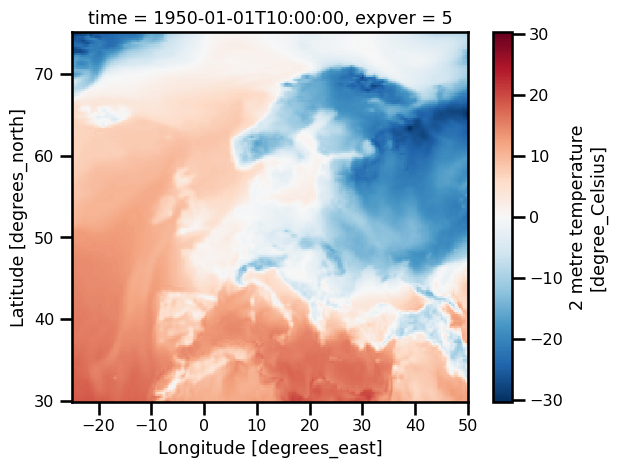

In [19]:
ds.t2m.isel(time=10, expver=1).plot.pcolormesh()

## Country Mask

In [20]:
ds = add_country_mask(ds, country="Spain")

In [21]:
ds

<xarray.Dataset>
Dimensions:     (time: 639912, lat: 181, lon: 301, expver: 2)
Coordinates:
  * lon         (lon) float32 -25.0 -24.75 -24.5 -24.25 ... 49.5 49.75 50.0
  * lat         (lat) float32 75.0 74.75 74.5 74.25 ... 30.75 30.5 30.25 30.0
  * time        (time) datetime64[ns] 1950-01-01 ... 2022-12-31T23:00:00
  * expver      (expver) int32 1 5
    spain_mask  (lat, lon) int16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    t2m         (time, lat, lon, expver) float32 dask.array<chunksize=(8760, 181, 301, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-03 14:44:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

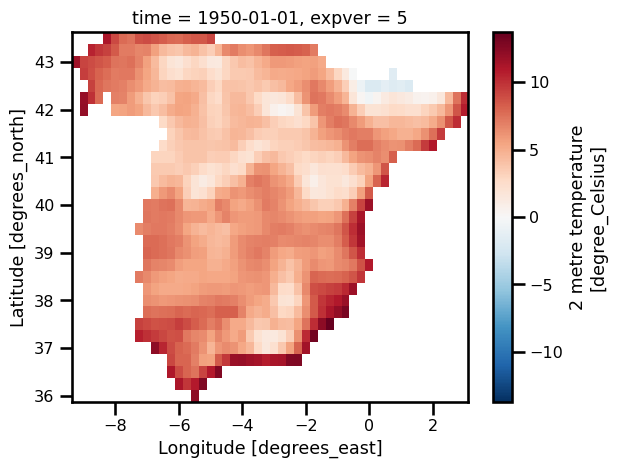

In [22]:
ds.isel(time=0, expver=1).where(ds.spain_mask==1, drop=True).t2m.plot()

## Block

In [23]:
ds_madrid = ds.sel(lon=-3.703790, lat=40.416775, expver=1, method="nearest")

In [36]:
# ds_madrid

In [37]:
extremes = ds_madrid.resample(time="1D").max().coarsen(time=365, side="center", boundary="trim").max()
# extremes = ds_madrid.resample(time="1D").max().coarsen(time=365, side="center", boundary="trim").max()

# extremes = ds_madrid.resample(time="1D").max().rolling(time=365, center=True).max()

In [39]:
extremes

<xarray.Dataset>
Dimensions:     (time: 73)
Coordinates:
    lon         float32 -3.75
    lat         float32 40.5
    expver      int32 1
    spain_mask  int16 1
  * time        (time) datetime64[ns] 1950-07-20 1951-07-20 ... 2022-07-02
Data variables:
    t2m         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-03 14:44:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

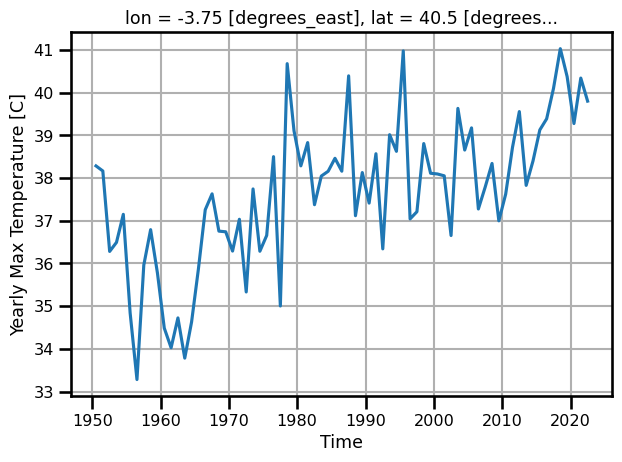

In [38]:
fig, ax = plt.subplots()

extremes.t2m.plot(ax=ax)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]"
)
plt.grid(which="both", visible=True)

plt.tight_layout()
plt.show()

## Peak Over Threshold

In [78]:
# resample time series
extremes = ds_madrid.t2m.compute()

In [117]:
# calculate threshold
threshold = extremes.quantile(q=[0.98], dim="time").values
threshold

array([33.06323059])

In [125]:
# calculate threshold
extremes_ = extremes.where(extremes >= threshold, drop=True)
# "decluster"
extremes_ = extremes_.coarsen(time=10, side="center", boundary="trim").max()
# extremes_ = extremes_.rolling(time=30, center=True).max()
extremes_
# .coarsen(time=30, side="center", boundary="trim").reduce(lambda x: x>)

<xarray.DataArray 't2m' (time: 1278)>
array([37.03528 , 37.79709 , 38.283813, ..., 35.73526 , 36.123444,
       34.82953 ], dtype=float32)
Coordinates:
    lon         float32 -3.75
    lat         float32 40.5
  * time        (time) datetime64[ns] 1950-06-28T00:30:00 ... 2022-09-06T06:0...
    expver      int32 1
    spain_mask  int16 1
Attributes:
    long_name:  2 metre temperature
    units:      degree_Celsius

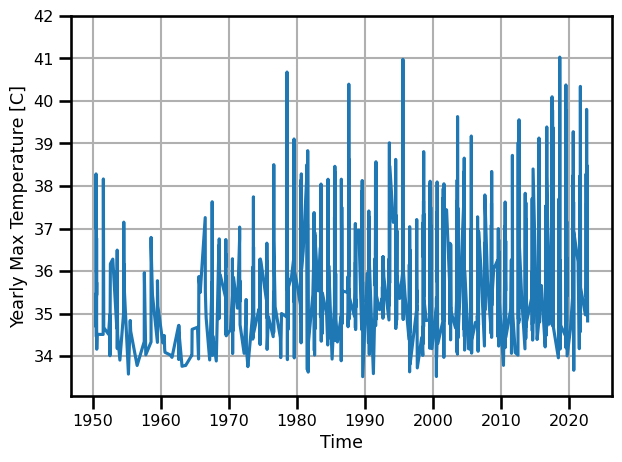

In [126]:
fig, ax = plt.subplots()

extremes_.plot(ax=ax)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]",
    ylim=[threshold, 42],
    title=""
)
plt.grid(which="both", visible=True)

plt.tight_layout()
plt.show()

In [34]:
# ds_madrid.t2m.resample(time="1ME").mean().plot()

## Rescale Time

In [10]:
t0 = ds["time"].min()
freq_dt = 12
freq_unit = "hours"

# time rescale
ds_ = time_rescale(ds, freq_dt=freq_dt, freq_unit=freq_unit)
ds_

<xarray.Dataset>
Dimensions:     (time: 639912, lat: 181, lon: 301, expver: 2)
Coordinates:
  * lon         (lon) float32 -25.0 -24.75 -24.5 -24.25 ... 49.5 49.75 50.0
  * lat         (lat) float32 75.0 74.75 74.5 74.25 ... 30.75 30.5 30.25 30.0
  * time        (time) float32 0.0 0.08333 0.1667 ... 5.333e+04 5.333e+04
  * expver      (expver) int32 1 5
    spain_mask  (lat, lon) int16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    t2m         (time, lat, lon, expver) float32 dask.array<chunksize=(8760, 181, 301, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-03 14:44:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [11]:
ds__ = time_unrescale(ds_)
ds__

<xarray.Dataset>
Dimensions:     (time: 639912, lat: 181, lon: 301, expver: 2)
Coordinates:
  * lon         (lon) float32 -25.0 -24.75 -24.5 -24.25 ... 49.5 49.75 50.0
  * lat         (lat) float32 75.0 74.75 74.5 74.25 ... 30.75 30.5 30.25 30.0
  * time        (time) datetime64[ns] 1950-01-01 ... 2022-12-31T23:00:56.2499...
  * expver      (expver) int32 1 5
    spain_mask  (lat, lon) int16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    t2m         (time, lat, lon, expver) float32 dask.array<chunksize=(8760, 181, 301, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-03 14:44:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...